<a href="https://colab.research.google.com/github/Novae28/Machine_learning/blob/main/Removing_background1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval() #using fcn with resnet backbone for image segmaentation

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

In [ ]:
import torchvision.transforms as T #transforming the image to input it in the fcn model
trans = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])

In [ ]:
img1 = Image.open('/content/view1.jpeg') # 
img2 = Image.open('/content/view2.jpeg')
img3 = Image.open('/content/view3.jpeg')

In [ ]:
inp1=trans(img1).unsqueeze(0) #transforming the images
inp2=trans(img2).unsqueeze(0)
inp3=trans(img3).unsqueeze(0)

In [ ]:
out1 = fcn(inp1)['out']
out2 = fcn(inp2)['out']
out3 = fcn(inp3)['out']
print (out1.shape) #finding out the dimentions of the output from the fcn
print (out2.shape)
print (out3.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 21, 224, 224])
torch.Size([1, 21, 224, 224])
torch.Size([1, 21, 224, 224])


In [ ]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval() #importing the pretrained resnet model for segmaentation
#this is a general purpose model and covers identification of a lot of objects such as birds,car,boat etc... 

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [ ]:
import cv2
def seg_decode(image, source, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8) #creating the RGB channels for the image
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc): # loop over each class color we stored in label_colors and we obtain the corresponding indexes in the image where that particular class label is present.
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2) #getting back the segmented RGB image.
  # Load the foreground input image
  foreground = cv2.imread(source)
  # Change the color of foreground image to RGB
  # and resize image to match shape of R-band in RGB output map
  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))
  # Create a background array to hold white pixels
  # with the same size as RGB output map
  background = 255 * np.ones_like(rgb).astype(np.uint8)
  # Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)
  # Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)
  # Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)
  # Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255
  # Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)
  # Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)
  # Add the masked foreground and background
  outImage = cv2.add(foreground, background)
  # Return a normalized output image for display
  return outImage/255

In [ ]:
import numpy as np

In [ ]:
#this function is a combination of all the transformation applied with processing the image back. This method requires GPU to run.
def bg_remove(net, path, show_orig=True,dev='cuda'): #dev='cuda' implies the usage of a GPU instance
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trans = T.Compose([T.Resize(640),     #transform function which was used earlier
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trans(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = def seg_decode(om,path)
  plt.imshow(rgb); plt.axis('off'); plt.show()

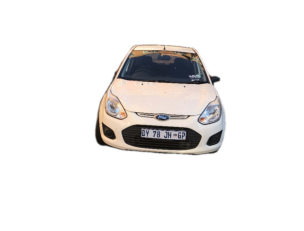

In [ ]:
segment(dlab, '/content/view1.jpeg', show_orig=False) #output image

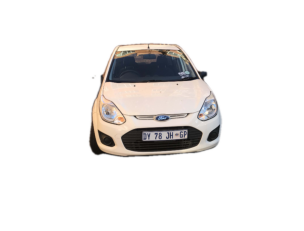

In [ ]:
segment(dlab, '/content/view2.jpeg', show_orig=False)

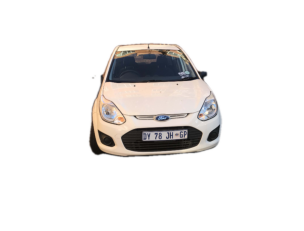

In [ ]:
segment(dlab, '/content/view2.jpeg', show_orig=False)